In [99]:
import numpy as np 
import pandas as pd 
import spacy
from sklearn.feature_extraction.text import CountVectorizer

In [100]:
v = CountVectorizer(ngram_range=(1,2)) 
## Here ngram_range = (x,y) means the countvectorizer will handle all grams between x and y

In [101]:
v.fit(["Hi there, I am Abhinav Aggarwal. It is nice to meet you"])
v.vocabulary_

{'hi': 6,
 'there': 16,
 'am': 4,
 'abhinav': 0,
 'aggarwal': 2,
 'it': 10,
 'is': 8,
 'nice': 14,
 'to': 18,
 'meet': 12,
 'you': 20,
 'hi there': 7,
 'there am': 17,
 'am abhinav': 5,
 'abhinav aggarwal': 1,
 'aggarwal it': 3,
 'it is': 11,
 'is nice': 9,
 'nice to': 15,
 'to meet': 19,
 'meet you': 13}

In [102]:
nlp = spacy.load('en_core_web_sm')
def preprocess(text):
    doc = nlp(text)
    filterTokens = list()
    
    for token in doc:
        if not (token.is_stop or token.is_punct):
            filterTokens.append(token.lemma_) 
    return " ".join(filterTokens)

In [103]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [104]:
newCorpus = list()
for i in corpus:
    newCorpus.append(preprocess(i))
newCorpus

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [105]:
v.fit(newCorpus)

CountVectorizer(ngram_range=(1, 2))

In [106]:
## Now make it as a bag of n_gram vector

In [107]:
v.transform(corpus).toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0]], dtype=int64)

### News Category Classification Problem

In [108]:
df = pd.read_json('news_dataset.json')
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [109]:
df['category'].value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [110]:
## If we have imbalanced class then we can use undersampling, oversampling, SMOTE technique to cater class imbalance
## Here to cater imbalance easily using undersampling, otherwise should use SMOTE

In [111]:
minSample = 1e8 
for i in df['category'].value_counts():
    minSample = min(minSample, i)
minSample

1381

In [112]:
df['category'].unique()

array(['SCIENCE', 'BUSINESS', 'CRIME', 'SPORTS'], dtype=object)

In [113]:
df_SCIENCE = df[df['category'] == 'SCIENCE'].sample(minSample, random_state=42)
df_BUSINESS = df[df['category'] == 'BUSINESS'].sample(minSample, random_state=42)
df_CRIME = df[df['category'] == 'CRIME'].sample(minSample, random_state=42)
df_SPORTS = df[df['category'] == 'SPORTS'].sample(minSample, random_state=42)

In [114]:
df_balanced = pd.concat([df_BUSINESS, df_SPORTS, df_CRIME, df_SCIENCE], axis=0)

In [115]:
df_balanced['category'].nunique()

4

In [127]:
df_balanced['preprocessed_text'] = df_balanced['text'].apply(preprocess)

In [158]:
def extract_features(text):
    # Tokenization, removing stopwords, and lemmatization
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    # POS tagging
    pos_tags = ' '.join([token.pos_ for token in doc])
    # Named Entity Recognition (NER)
    ner_tags = ' '.join([ent.label_ for ent in doc.ents])
    return ' '.join(tokens) + ' ' + pos_tags + ' ' + ner_tags

In [159]:
df_balanced['extracted_text'] = df_balanced['text'].apply(extract_features)

In [116]:
df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS' : 0,
    'SPORTS' : 1,
    'CRIME' : 2,
    'SCIENCE' : 3
})
df_balanced.drop(columns='category', inplace=True)
df_balanced

,text,category_num
594,How to Develop the Next Generation of Innovato...,0
3093,"Madoff Victims' Payout Nears $7.2 Billion, Tru...",0
7447,Bay Area Floats 'Sanctuary In Transit Policy' ...,0
10388,Microsoft Agrees To Acquire LinkedIn For $26.2...,0
1782,"Inside A Legal, Multibillion Dollar Weed Market",0
...,...,...
9924,A Call for Data Literacy If we care about youn...,3
10219,Here's What Happens When Someone Sneezes On An...,3
11884,Most People Don't See How Climate Change Is Af...,3
7854,"Watch Octopuses Meet for Blind Date, Tricky Se...",3


In [160]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_balanced['extracted_text'], df_balanced['category_num'], test_size=0.2, random_state=42, stratify= df_balanced['category_num'])
## Here stratify is important as this will make the splitting such that in both of the splits the class will be divided equally 

In [161]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [162]:
## We are making a pipeline by first using bag of words then naive bayes

clf = Pipeline([
    ('cnt_vectorizer', CountVectorizer()),
    ('Mutli_NB', MultinomialNB())
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)

print("The classification report is: \n", classification_report(y_test, pred))
print("\nThe accuracy score is: \n", accuracy_score(y_test, pred))
print("\nThe confusion matrix is: \n", confusion_matrix(y_test, pred))


The classification report is: 
               precision    recall  f1-score   support

           0       0.77      0.89      0.82       276
           1       0.86      0.86      0.86       276
           2       0.89      0.90      0.90       277
           3       0.90      0.75      0.82       276

    accuracy                           0.85      1105
   macro avg       0.86      0.85      0.85      1105
weighted avg       0.86      0.85      0.85      1105


The accuracy score is: 
 0.8497737556561086

The confusion matrix is: 
 [[245  16   6   9]
 [ 15 236  15  10]
 [ 19   5 250   3]
 [ 41  18   9 208]]


In [166]:
## This is by bag of words
clf = Pipeline([
    ('cnt_vectorizer', CountVectorizer(ngram_range=(1,2))),
    ('Mutli_NB', MultinomialNB())
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)

print("The classification report is: \n", classification_report(y_test, pred))
print("\nThe accuracy score is: \n", accuracy_score(y_test, pred))
print("\nThe confusion matrix is: \n", confusion_matrix(y_test, pred))


The classification report is: 
               precision    recall  f1-score   support

           0       0.57      0.92      0.70       276
           1       0.84      0.76      0.80       276
           2       0.88      0.82      0.85       277
           3       0.94      0.50      0.66       276

    accuracy                           0.75      1105
   macro avg       0.81      0.75      0.75      1105
weighted avg       0.81      0.75      0.75      1105


The accuracy score is: 
 0.7529411764705882

The confusion matrix is: 
 [[255  11   7   3]
 [ 50 210  14   2]
 [ 39   6 228   4]
 [104  22  11 139]]


In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(95.72222222222221, 0.5, 'Truth')

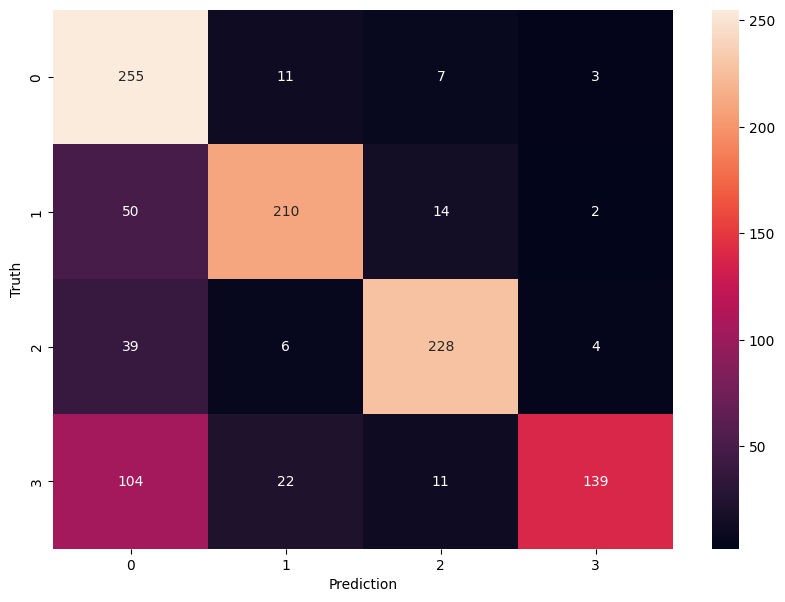

In [168]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [176]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(x_train)

CountVectorizer(ngram_range=(1, 2))

In [180]:
x_trainNew = v.transform(x_train.values).toarray()
x_testNew = v.transform(x_test.values).toarray()

In [181]:
x_trainNew

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [182]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

ValueError: could not convert string to float: 'Arby Employee Keeps Job refuse serve Police Arby apologize promise free combo meal Miami area police PROPN PART PROPN PROPN PROPN ADP VERB PART VERB PROPN PROPN PART VERB CCONJ VERB ADJ ADJ NOUN ADP PROPN PUNCT NOUN NOUN PUNCT ORG ORG GPE'